In [1]:
#import requests
import time 
import datetime
from google.cloud import bigquery
import os
import pandas as pd
from textblob import TextBlob


% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Authenticate

# os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/users/josephpope/Github/Fletcher/reddit-hate-speech-dc35623b7b98.json"

In [ ]:
# Instantiates a client

# client = bigquery.Client()

In [ ]:
# Function to clean row data from BigQuery 

# def row_to_dict(row):
#     return {k: row[v] for k, v in row._xxx_field_to_index.items()}

In [ ]:
# define relevant IDs in order to pull data from BigQuery account

# project_id = 'reddit-hate-speech'
# dataset_id = 'reddit_db'
# table_id = 'results_20180820_134202'

In [ ]:
# dataset_ref = client.dataset(dataset_id, project=project_id)
# table_ref = dataset_ref.table(table_id)
# table = client.get_table(table_ref)

In [ ]:
# Load all rows from a table

# rows = client.list_rows(table)

In [ ]:
# df = pd.DataFrame([row_to_dict(r) for r in rows])

In [2]:
df = pd.read_csv('reddit_data.csv')

In [3]:
df.shape

(115420, 17)

In [ ]:
# drop known bots from analysis 

bots = df[df['author'].str.contains('Bot')]['author'].unique()

In [ ]:
df = df[~df['author'].isin(bots)]

In [ ]:
df.shape

In [ ]:
# keep a copy of the dataframe with minimal text pre-processing in case interesting signals 
# exist in punctuation or stop words

# df1 = df.copy()

In [ ]:
# df1.to_csv('reddit_data.csv')

In [ ]:
import matplotlib.style as style
import seaborn as sns

In [ ]:
style.use('ggplot')

In [ ]:
ax = df.subreddit.value_counts()[:10].sort_values(ascending=True).plot(kind='barh')

ax.set_title('Most Common Subreddits by Comment Count');

In [ ]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
popular = df.groupby('subreddit')['subreddit_subscribers'].max().sort_values(ascending=False)

ax = popular[:10].sort_values(ascending=True).plot(kind='barh')

ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.set_title('Most Subscribed Subreddits');

In [ ]:
def explore_text(s):
    text = df[df.subreddit == str(s)].body.head()
    for i, post in enumerate(text):
        print("Post: " + str(i+1) + " " + str(post) + "\n")

In [ ]:
explore_text('worldnews')

## FEATURE ENGINEERING

In [4]:
# count words

df['word_count'] = df['body'].apply(lambda x: len(str(x).split(" ")))
df[['body','word_count']].head()

,body,word_count
0,"Is this just ""The Jew Show"" now, or is this ju...",17
1,"Wiehe points out that masturbation, hitherto a...",24
2,"Wiehe points out that masturbation, hitherto a...",24
3,You think the forcible removal of people is un...,51
4,>Gaza will become its own thing \n\nGaza is pr...,178


In [5]:
# count occurrences of 'jewish cowbell' triple parenthesis '(((like this)))'

df['cowbell'] = df['body'].apply(lambda x: len([x for x in x.split() if '(((' in x]))

In [6]:
# count occurences of uppercase words, which may indicate rage or anger

df['upper'] = df['body'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
df[['body','upper']].head()

,body,upper
0,"Is this just ""The Jew Show"" now, or is this ju...",1
1,"Wiehe points out that masturbation, hitherto a...",0
2,"Wiehe points out that masturbation, hitherto a...",0
3,You think the forcible removal of people is un...,1
4,>Gaza will become its own thing \n\nGaza is pr...,6


## TEXT CLEANUP

In [7]:
df['body'] = df['body'].apply(lambda x: x.lower());

Note -- Important to run stop words before removing punctuation. 

In [8]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['body'] = df['body'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df.body.head()

0              "the jew show" now, reality living nyc?
1    wiehe points masturbation, hitherto hole-in-co...
2    wiehe points masturbation, hitherto hole-in-co...
3    think forcible removal people unacceptable? ma...
4    >gaza become thing gaza predicted collapse ent...
Name: body, dtype: object

In [9]:
df['body'] = df['body'].str.replace('[^\w\s]','')

In [10]:
freq = pd.Series(' '.join(df['body']).split()).value_counts()[-10:]
freq

omnisentient                                   1
infeasible                                     1
midtown                                        1
septaugaint                                    1
pagehttpsenwikipediaorgwikisweden_democrats    1
schwager                                       1
entrustersnear                                 1
principlesim                                   1
whiteswhile                                    1
cfai                                           1
dtype: int64

In [11]:
# 10M word/token corpus  

df.word_count.sum()

10045833

In [12]:
df.head(1)

,Unnamed: 0,author,body,controversiality,created_utc,id,link_id,parent_id,permalink,s_author,s_domain,s_score,s_title,score,subreddit,subreddit_subscribers,word_count,cowbell,upper
0,0,bat_mayn,the jew show now reality living nyc,0,2018-06-26 19:57:00+00:00,30555910741,534217119,534217119,/r/TACN/comments/8u24kf/tacs_652_show_discussi...,jakdak,i.imgur.com,1.0,TACS 652 | Show Discussion,1,TACN,1411.0,17,0,1


## SENTIMENT ANALYSIS 

Using raw text, without pre-processing first produces poor results for word2vec. Similiar words are lumped together with misspellings and variations of the original word. Recommend comprehensive pre-processing before building a model. 

In [13]:
import gensim 

In [14]:
documents = np.array(df['body'])

In [15]:
documents[:2]

array(['the jew show now reality living nyc',
       'wiehe points masturbation hitherto holeincorner vice began shamelessly promoted first time weimar germany jewishrun organizations httpswwwveteranstodaycom20130924sexualdecadenceweimargermany'], dtype=object)

In [16]:
# tokenize words 

documents = [x.split(' ') for x in documents]

In [17]:
documents[:1]

[['the', 'jew', 'show', 'now', 'reality', 'living', 'nyc']]

In [ ]:
model = gensim.models.Word2Vec(
        documents,
        size=150,
        window=10,
        min_count=10,
        workers=10)

In [ ]:
model.train(documents, total_examples=len(df['body']), epochs=10)

In [ ]:
len(model.wv.vocab)

In [ ]:
w = 'holocaust'
model.wv.most_similar (positive = w)

In [ ]:
w = 'zionist'
model.wv.most_similar (positive = w)

In [ ]:
w = 'jew'
model.wv.most_similar (positive = w)

In [ ]:
w = 'kike'
model.wv.most_similar (positive = w)

In [ ]:
w = 'hitler'
model.wv.most_similar (positive = w)

In [ ]:
w = 'soros'
model.wv.most_similar (positive = w)

### TEXTBLOB SENTIMENT ANALYZER

In [18]:
def sentiment_finder(comment):
    
    analysis = TextBlob(comment)
    
    if analysis.sentiment.polarity > 0: 
        return 1 
    elif analysis.sentiment.polarity == 0:
        return 0
    else: 
        return -1

In [19]:
df['SA'] = np.array([ sentiment_finder(comment) for comment in df['body'] ])

In [20]:
df.head(1)

,Unnamed: 0,author,body,controversiality,created_utc,id,link_id,parent_id,permalink,s_author,s_domain,s_score,s_title,score,subreddit,subreddit_subscribers,word_count,cowbell,upper,SA
0,0,bat_mayn,the jew show now reality living nyc,0,2018-06-26 19:57:00+00:00,30555910741,534217119,534217119,/r/TACN/comments/8u24kf/tacs_652_show_discussi...,jakdak,i.imgur.com,1.0,TACS 652 | Show Discussion,1,TACN,1411.0,17,0,1,0


In [21]:
df[df['SA'] < 0].subreddit.value_counts()[:3]

worldnews    2578
politics     2137
AskReddit    1454
Name: subreddit, dtype: int64

In [22]:
def sentiment_finder_partial(comment):
    analysis = TextBlob(comment)
    return analysis.sentiment.polarity

In [23]:
df['SA_p'] = np.array([ sentiment_finder_partial(comment) for comment in df['body'] ])

In [24]:
df.head(1)

,Unnamed: 0,author,body,controversiality,created_utc,id,link_id,parent_id,permalink,s_author,...,s_score,s_title,score,subreddit,subreddit_subscribers,word_count,cowbell,upper,SA,SA_p
0,0,bat_mayn,the jew show now reality living nyc,0,2018-06-26 19:57:00+00:00,30555910741,534217119,534217119,/r/TACN/comments/8u24kf/tacs_652_show_discussi...,jakdak,...,1.0,TACS 652 | Show Discussion,1,TACN,1411.0,17,0,1,0,0.0


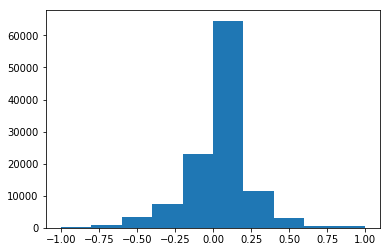

In [25]:
plt.hist(df.SA_p);

In [ ]:
# pos_comments = [ comment for index, comment in enumerate(df['body']) if df['SA'][index] > 0]
# neu_comments = [ comment for index, comment in enumerate(df['body']) if df['SA'][index] == 0]
# neg_comments = [ comment for index, comment in enumerate(df['body']) if df['SA'][index] < 0]

In [ ]:
# print("Percentage of positive comments: {:.1f}%".format(len(pos_comments)*100.0/len(df['body'])))
# print("Percentage of neutral comments: {:.1f}%".format(len(neu_comments)*100.0/len(df['body'])))
# print("Percentage de negative comments: {:.1f}%".format(len(neg_comments)*100.0/len(df['body'])))

In [ ]:
neg = df[df['SA'] < 0]

In [ ]:
df.groupby('author')['body'].count().sort_values(ascending=False)[:10]

In [ ]:
set(df[df['author'] == 'send_nasty_stuff'].subreddit)

#### T_SNE

In [ ]:
dfv = pd.Series(documents)

In [ ]:
vecs = pd.concat([dfv, df['subreddit']], axis=1)

In [ ]:
vecs.head()

## VADER SENTIMENT ANALYZER 

In [26]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

In [27]:
s = 'The food is good and the atmosphere is nice'
s

'The food is good and the atmosphere is nice'

In [28]:
snt = analyser.polarity_scores(s) # polarity_scores(s)
snt

{'compound': 0.6908, 'neg': 0.0, 'neu': 0.551, 'pos': 0.449}

In [29]:
snt['pos']

0.449

In [30]:
def sentiment_finder_vader(comment):
    #return the raw compound score 
    # if > .05, this is positve sentiment
    # if < .05, this is negative sentiment 
    # otherwise neutral     
        
    analysis = analyser.polarity_scores(comment)
    
    return analysis['compound']

In [31]:
df['Vader'] = np.array([ sentiment_finder_vader(comment) for comment in df['body'] ])

In [ ]:
senti_vader = df.groupby('subreddit')['Vader'].mean()

In [32]:
df.head(1)

,Unnamed: 0,author,body,controversiality,created_utc,id,link_id,parent_id,permalink,s_author,...,s_title,score,subreddit,subreddit_subscribers,word_count,cowbell,upper,SA,SA_p,Vader
0,0,bat_mayn,the jew show now reality living nyc,0,2018-06-26 19:57:00+00:00,30555910741,534217119,534217119,/r/TACN/comments/8u24kf/tacs_652_show_discussi...,jakdak,...,TACS 652 | Show Discussion,1,TACN,1411.0,17,0,1,0,0.0,0.0


In [33]:
import pickle

In [34]:
df.to_pickle("clean_df.pkl")

In [35]:
df.to_csv("clean_df.csv")

In [ ]:
subs = df.groupby(['subreddit'])['subreddit_subscribers'].max()

In [ ]:
comments = df.groupby(['subreddit'])['body'].count()

In [ ]:
senti = df.groupby('subreddit')['SA'].mean()

In [ ]:
hist = sns.distplot(senti_vader, bins=20)

In [ ]:
ax1 = sns.scatterplot(subs, comments, hue=senti, );

ax1.set_ylabel('Comment Count');
ax1.set_xlabel('Subreddit Sub Count');

In [ ]:
ax2 = sns.scatterplot(subs, comments, hue=senti_vader, );

ax2.set_ylabel('Comment Count');
ax2.set_xlabel('Subreddit Sub Count');

In [ ]:
word_count = df.groupby(['subreddit'])['word_count'].sum()

In [ ]:
style.available

In [ ]:
df.head(1)

In [ ]:
sub_score = df.groupby(['subreddit'])['s_score'].mean()

In [ ]:
sns.set()
style.use('seaborn-white')

cmap = sns.diverging_palette(240, 10, n=20, as_cmap=True)
ax3 = sns.scatterplot(word_count, comments, hue=senti_vader, palette=cmap
                      );

ax3.set_ylabel('Comment Count');
ax3.set_xlabel('Word Count');

In [ ]:
df[df['Vader'] == df['Vader'].min()]

In [ ]:
# list(df1[df1['author'] == 'LivingWater404'][3:]['body'])[0][:100]

## TOPIC MODELING

#### NMF - COUNT VECTORIZER

In [36]:
import sklearn.feature_extraction.text as text

vectorizer = text.CountVectorizer(min_df=5)

In [37]:
n_samples = 40000
n_features = 2000
n_topics = 5
n_top_words = 10

In [38]:
dtm = vectorizer.fit_transform(df['body'])

In [39]:
vocab = np.array(vectorizer.get_feature_names())

In [40]:
dtm.shape

(115420, 33847)

In [41]:
len(vocab)

33847

In [42]:
from sklearn import decomposition

In [43]:
clf = decomposition.NMF(n_components=n_topics, random_state=1)

In [44]:
doctopic = clf.fit_transform(dtm)

In [45]:
topic_words = []

for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:n_top_words]
    topic_words.append([vocab[i] for i in word_idx])

In [46]:
for topic in topic_words:
    print(topic[:20])

['would', 'one', 'like', 'even', 'also', 'think', 'way', 'time', 'us', 'many']
['im', 'it', 'bee', 'know', 'thats', 'right', 'bees', 'you', 'like', 'get']
['people', 'said', 'kike', 'white', 'black', 'like', 'think', 'want', 'racist', 'jewish']
['god', 'jesus', 'christ', 'one', 'believe', 'life', 'lord', 'bible', 'man', 'gods']
['jews', 'israel', 'jewish', 'palestinians', 'land', 'state', 'israeli', 'palestine', 'arab', 'arabs']


In [52]:
topicmax = list()
for topic in doctopic:
    topicmax.append(argmax(topic))

In [67]:
topicmax = np.array(topicmax)

In [72]:
df['topicmax'] = topicmax

In [75]:
df.topicmax.value_counts()

4    52879
0    28820
2    16382
1    12448
3     4891
Name: topicmax, dtype: int64

In [78]:
df[df.topicmax == 2].subreddit.value_counts()[:10]

politics                1034
worldnews                956
AskReddit                738
milliondollarextreme     506
conspiracy               439
news                     427
CringeAnarchy            396
The_Donald               380
pics                     254
Judaism                  226
Name: subreddit, dtype: int64

In [79]:
df.to_csv('clean_df.csv')

#### NMF - TF_IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

tfidf_vectorizer = TfidfVectorizer(min_df = 5, max_df = 1000)

In [ ]:
tf_idf = tfidf_vectorizer.fit_transform(df['body'])

In [ ]:
tf_idf.shape

In [ ]:
tfidf_vocab = np.array(tfidf_vectorizer.get_feature_names())

In [ ]:
clf = decomposition.NMF(n_components=n_topics, random_state=1)

In [ ]:
tfidf_doctopic = clf.fit_transform(tf_idf)

In [ ]:
topic_words = []

for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:n_top_words]
    topic_words.append([tfidf_vocab[i] for i in word_idx])

In [ ]:
for topic in topic_words:
    print(topic[:20])

#### Rerun after lemmatizing corpus 

In [ ]:
from nltk.stem import WordNetLemmatizer

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def lemmatiz(comment):
    return [lemmatizer.lemmatize(w) for w in comment.split(' ')]

In [ ]:
t = df['body'][5]
t

In [ ]:
lemmatiz(t);

In [ ]:
df['lemma'] = np.array([ lemmatiz(comment) for comment in df['body'] ])

In [ ]:
df['lemma'] = df['lemma'].apply(lambda x: ' '.join(x))

In [ ]:
tf_idf = tfidf_vectorizer.fit_transform(df['lemma'])

In [ ]:
tf_idf.shape

In [ ]:
tfidf_vocab = np.array(tfidf_vectorizer.get_feature_names())

In [ ]:
clf = decomposition.NMF(n_components=6, random_state=1)

In [ ]:
tfidf_doctopic = clf.fit_transform(tf_idf)

In [ ]:
topic_words = []

for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:n_top_words]
    topic_words.append([tfidf_vocab[i] for i in word_idx])

In [ ]:
for topic in topic_words:
    print(topic[:20])

#### LEMMATIZE - NMF - COUNT VECTORIZER

In [ ]:
dtm = vectorizer.fit_transform(df['lemma'])

In [ ]:
vocab = np.array(vectorizer.get_feature_names())

In [ ]:
dtm.shape

In [ ]:
len(vocab)

In [ ]:
clf = decomposition.NMF(n_components=6, random_state=1)

In [ ]:
doctopic = clf.fit_transform(dtm)

In [ ]:
topic_words = []

for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:n_top_words]
    topic_words.append([vocab[i] for i in word_idx])

In [ ]:
for topic in topic_words:
    print(topic[:20])

## K-MEANS CLUSTERING

In [ ]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_doctopic)

In [ ]:
clusters = np.array(km.labels_)

In [ ]:
# from sklearn.metrics.pairwise import cosine_similarity
# dist = 1 - cosine_similarity(tfidf_doctopic)

In [ ]:
# df.columns

In [ ]:
# comments = { 'subreddit': df['subreddit'], 'author': df['author'], 'cluster': clusters, }

# frame = pd.DataFrame(comments, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

scattertext - compare subreddit word frequencies. 

https://github.com/JasonKessler/scattertext

- the_donald vs alt.right 
- politics vs worldnews 
- worldnews vs worldpolitics 
- israel vs palestine(?)/arab subreddits

